In [1]:
# '=== Header Start ==='
# Title:       Section5_Analysis_of_Isoform_Unique_Regulon
# Author:      Wanqi Li, Jingmin An
# Date:        20240522
# Purpose:     Analysis of isoform regulon mentioned in Section 5
# Source Data: Regulon database extracted in this study, mentioned in Section 4
# '=== Header End ==='

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy import stats
import os, glob

In [2]:
def wq_calculate_unique_regulon_statistics_by_TF(df, flag_save = False, path_csv = "unique_interaction_isoform_byTF.csv"):
    # input df columns: tf, unique_interaction_count, unique_interaction_ratio
    df_all = df
    df_all[['isoform', 'tf_main']] = df_all['tf'].str.split('-', n=1, expand=True)
    
    # calculate number of isoform per TF
    TF_isoform_count = df_all.groupby("tf_main").count()
    TF_isoform_count["TFname"] = TF_isoform_count.index
    TF_isoform_count = TF_isoform_count[["TFname", "tf"]]
    TF_isoform_count.columns = ["TFname", "count"]
    
    # calculate mean, var, std, cv of count and ratio, by TF
    TF_isoform_unique_interaction = df_all[["tf_main", "unique_interaction_count", "unique_interaction_ratio"]].groupby('tf_main').agg(['mean', 'var', np.std, 'max', 'min'])
    TF_isoform_unique_interaction.columns = ["unique_interaction_count_mean", "unique_interaction_count_var", "unique_interaction_count_std", 
                                             "unique_interaction_count_max", "unique_interaction_count_min",
                                             "unique_interaction_ratio_mean", "unique_interaction_ratio_var", "unique_interaction_ratio_std",
                                             "unique_interaction_ratio_max", "unique_interaction_ratio_min"]
    TF_isoform_unique_interaction["unique_interaction_count_cv"] = TF_isoform_unique_interaction["unique_interaction_count_std"] / TF_isoform_unique_interaction["unique_interaction_count_mean"]
    TF_isoform_unique_interaction["unique_interaction_count_range"] = TF_isoform_unique_interaction["unique_interaction_count_max"] - TF_isoform_unique_interaction["unique_interaction_count_min"]
    TF_isoform_unique_interaction["unique_interaction_ratio_cv"] = TF_isoform_unique_interaction["unique_interaction_ratio_std"] / TF_isoform_unique_interaction["unique_interaction_ratio_mean"]
    TF_isoform_unique_interaction["unique_interaction_ratio_range"] = TF_isoform_unique_interaction["unique_interaction_ratio_max"] - TF_isoform_unique_interaction["unique_interaction_ratio_min"]
    TF_isoform_unique_interaction["TFname"] = TF_isoform_unique_interaction.index
    TF_isoform_unique_interaction = TF_isoform_count.merge(TF_isoform_unique_interaction, on="TFname", how="outer")
    
    if flag_save:
        TF_isoform_unique_interaction.to_csv(path_csv, index = True, sep = ",")
    return TF_isoform_unique_interaction


In [27]:
def wq_plot_unique_interaction_statistic(data, x, y, title, xlabel, ylabel, kind = "scatter", hue=None, flag_p = False,
                                         vline = False, v = None, hline = False, h = None,
                                         x_lim = None, y_lim = None,
                                         flag_save = False, path_fig = "unique_interaction.png"):
    g = sns.jointplot(data=data, x=x, y=y, marginal_kws=dict(bins=25), kind = kind, hue=hue,
                      height = 4)
    g.plot_joint(sns.kdeplot, color="gray", zorder=0, levels=6)

    cor, p = stats.pearsonr(data[x], data[y])
    cor_f = "{:.2e}".format(cor)
    p_f = "{:.2e}".format(p)
    # center_x = g.get_xlim()[0] + (g.get_xlim()[1] - g.get_xlim()[0]) / 2
    # max_y = g.get_ylim()[1] * 0.9
    if flag_p:
        plt.text(0.5, 0.3, "pearson r="+str(cor_f)+"\n"+"p="+str(p_f), ha="center", va = "top")
    print("pearson r="+str(cor_f)+"\n"+"p="+str(p_f))

    if vline:
        plt.axvline(x = v, color = "gray", linestyle = "--")
    if hline:
        plt.axhline(y = h, color = "gray", linestyle = "--")

    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
    
    plt.title(title, y=1.2, fontsize=15)
    plt.xlabel(xlabel, fontsize=10)  
    plt.ylabel(ylabel, fontsize=10) 
    plt.tight_layout() 
    if flag_save:
        plt.savefig(path_fig, dpi=600, bbox_inches = "tight")
    plt.show()

In [4]:
def wq_plot_unique_interaction_statistic_with_focus(TF_isoform_unique_interaction_filter, focus_gene_list, data_name, x, y, title, xlabel, ylabel, kind = "scatter", hue=None,
                                                    vline = False, v = None, hline = False, h = None,
                                                    flag_save = False, path_fig = "unique_interaction.png"):
    # turn to upper version
    focus_gene_list = [s.upper() for s in focus_gene_list]
    # focus_gene_list
    focus_gene_list_name = data_name
    TF_isoform_unique_interaction_filter_note = TF_isoform_unique_interaction_filter.copy()
    TF_isoform_unique_interaction_filter_note["annotation"] = "" * len(TF_isoform_unique_interaction_filter_note)
    for rowname in TF_isoform_unique_interaction_filter_note.index:
        if TF_isoform_unique_interaction_filter_note.loc[rowname, "TFname"] in focus_gene_list:
            TF_isoform_unique_interaction_filter_note.loc[rowname, "annotation"] = focus_gene_list_name
        # print(TF_isoform_unique_interaction_filter_note.loc[rowname, "TFname"])
    data = TF_isoform_unique_interaction_filter_note

    data = data.sort_values(hue)
    # g = sns.jointplot(data=data, x=x, y=y, kind = kind, hue=hue,
    #                   height = 4)
    # g.plot_joint(sns.kdeplot, color="gray", zorder=0, levels=6)
    # plt.figure(figsize=(4, 4))
    fig=plt.figure(figsize=(7, 4), constrained_layout = True)
    gs = fig.add_gridspec(2,2)
    ax_left = fig.add_subplot(gs[:,0])
    sns.scatterplot(data=data, x=x, y=y, hue=hue)
    # ax_left.set_title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=10)  
    plt.ylabel(ylabel, fontsize=10) 
    plt.legend(loc='upper left')
    if vline:
        plt.axvline(x = v, color = "gray", linestyle = "--")
    if hline:
        plt.axhline(y = h, color = "gray", linestyle = "--")

    
    ax_right1 = fig.add_subplot(gs[0,1])
    sns.histplot(data=data, x=x, hue=hue, ax=ax_right1, kde=True)

    KS_stat, KS_p = stats.ks_2samp(data.loc[data[hue]=="", x], data.loc[data[hue]!="", x])
    KS_stat_f = "{:.2e}".format(KS_stat)
    KS_p_f = "{:.2e}".format(KS_p)
    center_x = ax_right1.get_xlim()[0] + (ax_right1.get_xlim()[1] - ax_right1.get_xlim()[0]) / 2
    max_y = ax_right1.get_ylim()[1] * 0.9
    plt.text(center_x, max_y, "KS_stat="+str(KS_stat_f)+"\n"+"KS_p="+str(KS_p_f), ha="center", va = "top")
    ax_right1.legend_.remove()
    # plt.xlabel("")

    ax_right2 = fig.add_subplot(gs[1,1])
    sns.histplot(data=data, x=y, hue=hue, ax=ax_right2, kde=True)

    KS_stat, KS_p = stats.ks_2samp(data.loc[data[hue]=="", y], data.loc[data[hue]!="", y])
    KS_stat_f = "{:.2e}".format(KS_stat)
    KS_p_f = "{:.2e}".format(KS_p)
    center_x = ax_right2.get_xlim()[0] + (ax_right2.get_xlim()[1] - ax_right2.get_xlim()[0]) / 2
    max_y = ax_right2.get_ylim()[1] * 0.9
    plt.text(center_x, max_y, "KS_stat="+str(KS_stat_f)+"\n"+"KS_p="+str(KS_p_f), ha="center", va = "top")
    ax_right2.legend_.remove()

    
    plt.suptitle(title, fontsize=15)
    plt.tight_layout() 
    if flag_save:
        plt.savefig(path_fig, dpi=600, bbox_inches = "tight")
    plt.show()

In [ ]:
# count unique interaction
import pandas as pd
from tqdm.auto import tqdm

df = pd.read_csv('../data/regulon/regulon_E_FC=2.5_p=0.05_distinct.csv')

# Split the 'tf' column into 'isoform' and 'tf_main'
df[['isoform', 'tf_main']] = df['tf'].str.split('-', n=1, expand=True)

# Calculate unique isoform per tf_main
unique_isoforms = df.groupby('tf_main')['isoform'].nunique()

# Initialize a progress bar
tqdm.pandas(desc="Progress", total=df['isoform'].nunique())

unique_interaction_data = []

# Process each TF to find unique interactions per isoform
for tf_main in tqdm(df['tf_main'].unique(), desc="Progress"):
    tf_df = df[df['tf_main'] == tf_main]

    for isoform in tf_df['isoform'].unique():
        isoform_df = tf_df[tf_df['isoform'] == isoform]
        # The targets influenced by the current isoform
        isoform_targets = isoform_df[['target', 'ESC_mor']].drop_duplicates()

        # Data for other isoforms of the same TF
        other_isoforms_df = tf_df[tf_df['isoform'] != isoform]
        # The targets influenced by other isoforms
        other_targets = other_isoforms_df[['target', 'ESC_mor']].drop_duplicates()

        # Find the unique interactions for the current isoform, considering both target and mor
        unique_interactions = isoform_targets[~isoform_targets.apply(tuple, 1).isin(other_targets.apply(tuple, 1))]

        # Count the unique interactions
        unique_count = unique_interactions.shape[0]

        # Calculate the ratio of unique interactions to total interactions
        total_interactions = isoform_df.shape[0]
        unique_ratio = unique_count / total_interactions if total_interactions else 0

        # Store the results
        unique_interaction_data.append({
            'tf': f'{isoform}-{tf_main}',
            'unique_interaction_count': unique_count,
            'unique_interaction_ratio': unique_ratio
        })

unique_interaction_isoform_df = pd.DataFrame(unique_interaction_data)

# Save the DataFrame to a CSV file
unique_interaction_isoform_df.to_csv('../data/Section5&6_Isoform/unique_interaction_isoform.csv', index=False)

In [50]:
unique_interaction_isoform = pd.read_csv("../data/Section5&6_Isoform/unique_interaction_isoform.csv")
unique_interaction_isoform

,tf,unique_interaction_count,unique_interaction_ratio
0,TFORF0001-HIF3A,346,0.722338
1,TFORF0002-HIF3A,200,0.677966
2,TFORF0003-HIF3A,430,0.777577
3,TFORF0004-HIF3A,202,0.742647
4,TFORF0005-HIF3A,319,0.759524
...,...,...,...
3245,TFORF3538-HOXD10,304,1.000000
3246,TFORF3540-TAL2,179,1.000000
3247,TFORF3542-ZNF720,498,1.000000
3248,TFORF3543-CSDC2,153,1.000000


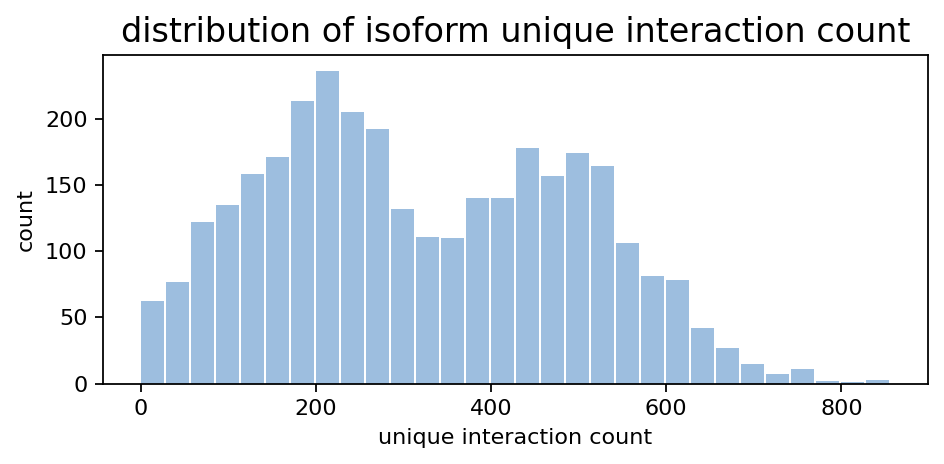

In [83]:
# plot distribution of unique count
plt.figure(figsize=(6, 3), dpi=160)
plt.hist(unique_interaction_isoform["unique_interaction_count"], bins = 30, width = 27, color = "#9dbedf")
plt.ylabel("count", fontsize=10)
plt.xlabel("unique interaction count", fontsize=10)   
# plt.xticks(range(0, max(TF_isoform_unique_interaction["in cluster4 ratio"]), 2))
# plt.yticks(range(0, 250, 50))
# plt.yscale("log")
plt.title("distribution of isoform unique interaction count", fontsize=15)  
plt.tight_layout() 
plt.savefig('../data/Section5&6_Isoform/image/isoform_unique_interaction_count_distribution.pdf')

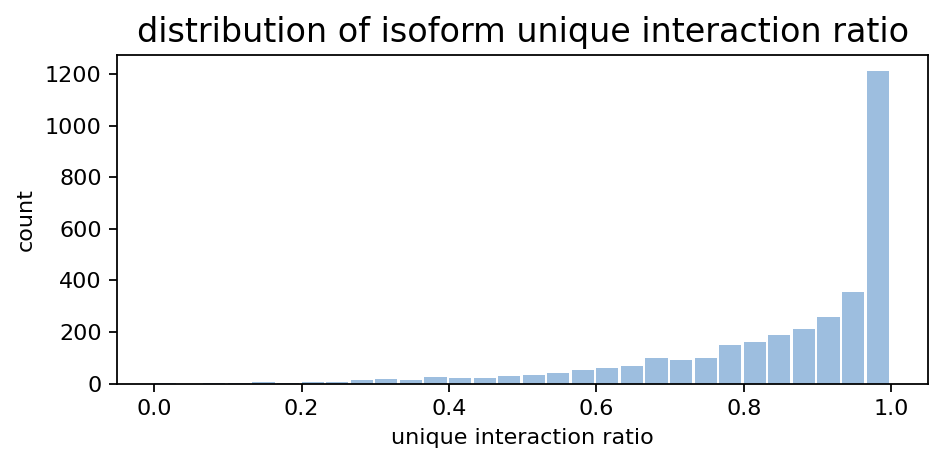

In [81]:
# plot distribution of unique ratio
plt.figure(figsize=(6, 3), dpi=160)
plt.hist(unique_interaction_isoform["unique_interaction_ratio"], bins = 30, width = 0.03, color = "#9dbedf")
plt.ylabel("count", fontsize=10)
plt.xlabel("unique interaction ratio", fontsize=10)   
plt.title("distribution of isoform unique interaction ratio", fontsize=15)  
plt.tight_layout() 
plt.savefig('../data/Section5&6_Isoform/image/isoform_unique_interaction_ratio_distribution.pdf')

In [8]:
# TF_isoform_unique_interaction = wq_calculate_unique_regulon_statistics_by_TF(unique_interaction_isoform, 
#                                                                              flag_save = True, path_csv = "../data/Section5&6_Isoform/unique_interaction_isoform_byTF.csv")
TF_isoform_unique_interaction = pd.read_csv("../data/Section5&6_Isoform/unique_interaction_isoform_byTF.csv", index_col = 0)
TF_isoform_unique_interaction

,TFname,count,unique_interaction_count_mean,unique_interaction_count_var,unique_interaction_count_std,unique_interaction_count_max,unique_interaction_count_min,unique_interaction_ratio_mean,unique_interaction_ratio_var,unique_interaction_ratio_std,unique_interaction_ratio_max,unique_interaction_ratio_min,unique_interaction_count_cv,unique_interaction_count_range,unique_interaction_ratio_cv,unique_interaction_ratio_range
0,AATF,1,534.0,NaN,NaN,534,534,1.000000,NaN,NaN,1.000000,1.000000,NaN,0,NaN,0.000000
1,ABL1,1,220.0,NaN,NaN,220,220,1.000000,NaN,NaN,1.000000,1.000000,NaN,0,NaN,0.000000
2,ACTL6A,2,384.5,28560.5,168.998521,504,265,0.913905,0.001215,0.034850,0.938547,0.889262,0.439528,239,0.038133,0.049286
3,ADAR,2,497.0,48050.0,219.203102,652,342,0.963618,0.000241,0.015516,0.974589,0.952646,0.441053,310,0.016102,0.021943
4,ADNP2,1,343.0,NaN,NaN,343,343,1.000000,NaN,NaN,1.000000,1.000000,NaN,0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,ZSCAN9,1,615.0,NaN,NaN,615,615,1.000000,NaN,NaN,1.000000,1.000000,NaN,0,NaN,0.000000
1713,ZXDA,1,500.0,NaN,NaN,500,500,1.000000,NaN,NaN,1.000000,1.000000,NaN,0,NaN,0.000000
1714,ZXDB,1,147.0,NaN,NaN,147,147,1.000000,NaN,NaN,1.000000,1.000000,NaN,0,NaN,0.000000
1715,ZXDC,2,535.5,8320.5,91.216775,600,471,0.934540,0.000109,0.010430,0.941915,0.927165,0.170339,129,0.011160,0.014750


In [29]:
# assign threshold by cluster identified in section 4
TF_isoform_unique_interaction = pd.read_csv("../data/Section5&6_Isoform/unique_interaction_isoform_byTF_clusterinfo.csv", index_col = 0)
focus_TFs = TF_isoform_unique_interaction[TF_isoform_unique_interaction["count"]>1]
focus_TFs = focus_TFs[focus_TFs["in cluster4 ratio"]==1]
focus_TFs.to_csv("../data/Section5&6_Isoform/unique_interaction_isoform_byTF_cluster4_identical_TFs.csv", index = True, sep = ",")
focus_TFs

,TFname,count,in cluster4,in cluster4 ratio,unique_interaction_count_mean,unique_interaction_count_var,unique_interaction_count_std,unique_interaction_count_max,unique_interaction_count_min,unique_interaction_ratio_mean,unique_interaction_ratio_var,unique_interaction_ratio_std,unique_interaction_ratio_max,unique_interaction_ratio_min,unique_interaction_count_cv,unique_interaction_count_range,unique_interaction_ratio_cv,unique_interaction_ratio_range
ATF3,ATF3,4,4.0,1.0,69.500000,499.000000,22.338308,102,51,0.446819,0.003927,0.062664,0.534031,0.395349,0.321415,51,0.140245,0.138683
BATF2,BATF2,3,3.0,1.0,97.666667,785.333333,28.023799,125,69,0.599401,0.005919,0.076933,0.672043,0.518797,0.286933,56,0.128349,0.153246
CAMTA1,CAMTA1,2,2.0,1.0,111.000000,98.000000,9.899495,118,104,0.652352,0.000410,0.020244,0.666667,0.638037,0.089185,14,0.031033,0.028630
CHURC1,CHURC1,3,3.0,1.0,87.333333,126.333333,11.239810,97,75,0.507966,0.000864,0.029398,0.541899,0.490196,0.128700,22,0.057874,0.051703
ESRRA,ESRRA,2,2.0,1.0,125.000000,72.000000,8.485281,131,119,0.686472,0.000214,0.014617,0.696809,0.676136,0.067882,12,0.021294,0.020672
HELT,HELT,2,2.0,1.0,126.000000,32.000000,5.656854,130,122,0.692159,0.000092,0.009568,0.698925,0.685393,0.044896,8,0.013824,0.013531
HMGA2,HMGA2,5,5.0,1.0,62.000000,463.500000,21.529050,91,38,0.407002,0.004252,0.065207,0.478947,0.336283,0.347243,53,0.160213,0.142664
HOPX,HOPX,3,3.0,1.0,93.000000,684.000000,26.153394,111,63,0.556819,0.005186,0.072015,0.600000,0.473684,0.281219,48,0.129333,0.126316
HOXA1,HOXA1,2,2.0,1.0,135.500000,40.500000,6.363961,140,131,0.738262,0.000082,0.009077,0.744681,0.731844,0.046967,9,0.012296,0.012837
HOXB8,HOXB8,2,2.0,1.0,96.500000,12.500000,3.535534,99,94,0.663131,0.000067,0.008186,0.668919,0.657343,0.036638,5,0.012344,0.011576


In [30]:
mid_mean = max(focus_TFs["unique_interaction_ratio_mean"])
mid_range = max(focus_TFs["unique_interaction_ratio_range"])
print("threshold of mean:", mid_mean)
print("threshold of range:", mid_range)

threshold of mean: 0.7382622132414121
threshold of range: 0.1532460182714851


In [31]:
TF_isoform_unique_interaction_filter = TF_isoform_unique_interaction[TF_isoform_unique_interaction["count"]!=1]

pearson r=-7.39e-01
p=1.68e-134


/tmp/ipykernel_3518395/918578215.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


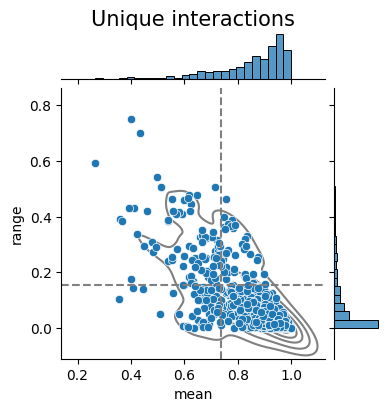

In [ ]:
wq_plot_unique_interaction_statistic(TF_isoform_unique_interaction_filter, x="unique_interaction_ratio_mean", y="unique_interaction_ratio_range", 
                                     title="Unique interactions", xlabel="mean", ylabel="range",
                                     vline = True, v = mid_mean, hline = True, h = mid_range,
                                     flag_save = True, path_fig = "../data/Section5&6_Isoform/image/unique_interaction_mean_range.png")

/tmp/ipykernel_3518395/1144408294.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


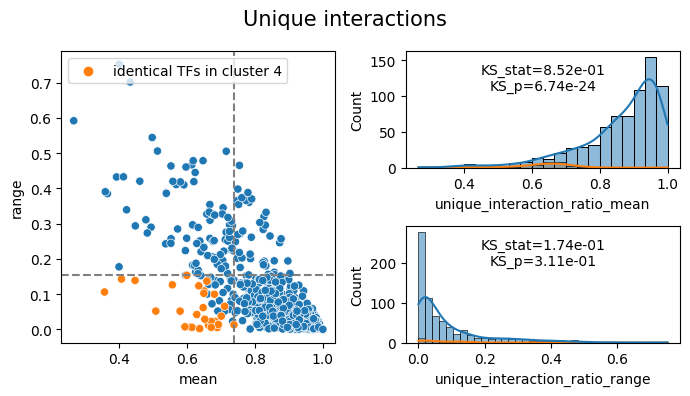

In [ ]:
data_name = "identical TFs in cluster 4"
focus_gene_list = focus_TFs["TFname"]
wq_plot_unique_interaction_statistic_with_focus(TF_isoform_unique_interaction_filter,
                                                focus_gene_list = focus_gene_list,
                                                data_name = data_name, x="unique_interaction_ratio_mean", y="unique_interaction_ratio_range", 
                                                hue = "annotation",
                                                title="Unique interactions", xlabel="mean", ylabel="range",
                                                vline = True, v = mid_mean, hline = True, h = mid_range,
                                                flag_save = True, path_fig = "../data/Section5&6_Isoform/image/unique_interaction_mean_range_"+data_name+".pdf")

/tmp/ipykernel_3518395/1144408294.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


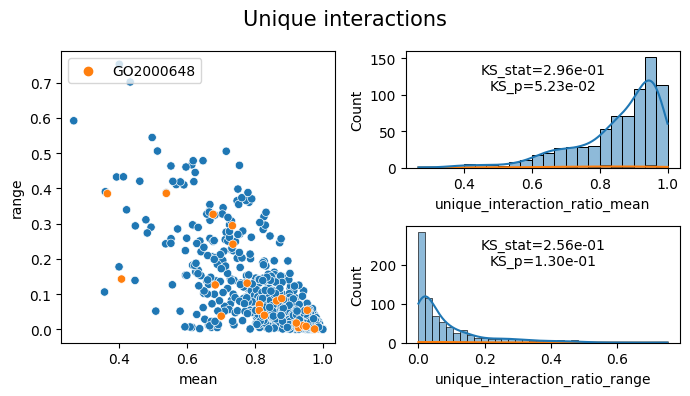

In [43]:
data_name = "GO2000648"
data_path = "../data/Section5&6_Isoform/GO2000648 positive regulation of stem cell proliferation.txt"
focus_gene_list_df = pd.read_csv(data_path, sep="\t", header=None)
focus_gene_list = focus_gene_list_df[1].values
wq_plot_unique_interaction_statistic_with_focus(TF_isoform_unique_interaction_filter, focus_gene_list, 
                                                data_name = data_name, x="unique_interaction_ratio_mean", y="unique_interaction_ratio_range", 
                                                hue = "annotation",
                                                title="Unique interactions", xlabel="mean", ylabel="range",
                                                flag_save = True, path_fig = "../data/Section5&6_Isoform/image/unique_interaction_mean_range_"+data_name+".png")

/tmp/ipykernel_3518395/1144408294.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


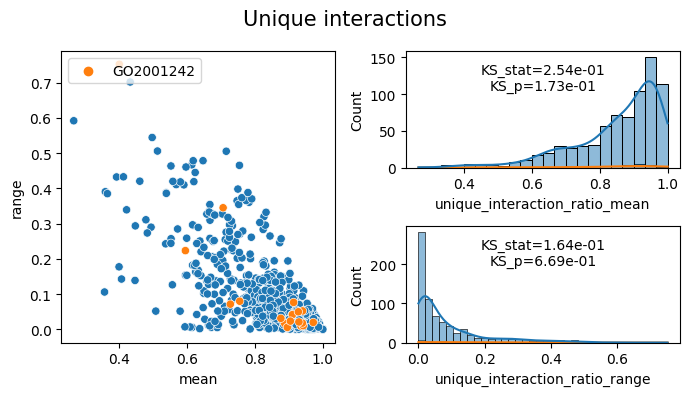

In [45]:
data_name = "GO2001242"
data_path = "../data/Section5&6_Isoform/GO2001242 regulation of intrinsic apoptotic signaling pathway.txt"
focus_gene_list_df = pd.read_csv(data_path, sep="\t", header=None)
focus_gene_list = focus_gene_list_df[1].values
wq_plot_unique_interaction_statistic_with_focus(TF_isoform_unique_interaction_filter,
                                                focus_gene_list, 
                                                data_name = data_name, x="unique_interaction_ratio_mean", y="unique_interaction_ratio_range", 
                                                hue = "annotation",
                                                title="Unique interactions", xlabel="mean", ylabel="range",
                                                flag_save = True, path_fig = "../data/Section5&6_Isoform/image/unique_interaction_mean_range_"+data_name+".pdf")

/tmp/ipykernel_526146/2204260708.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


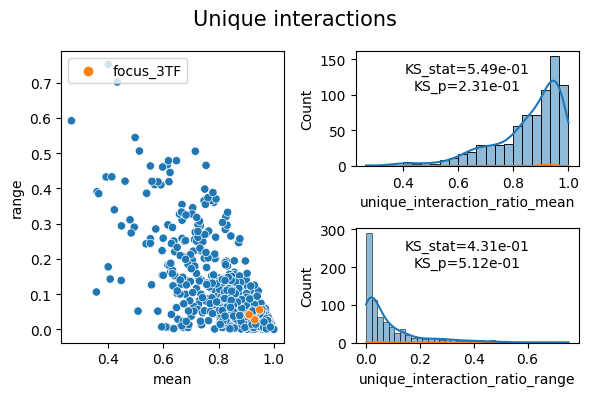

In [40]:
data_name = "focus_3TF"
wq_plot_unique_interaction_statistic_with_focus(TF_isoform_unique_interaction_filter,
                                                data_path = "../data/Section5&6_Isoform/focus_3TF.txt", 
                                                data_name = data_name, x="unique_interaction_ratio_mean", y="unique_interaction_ratio_range", 
                                                hue = "annotation",
                                                title="Unique interactions", xlabel="mean", ylabel="range",
                                                flag_save = True, path_fig = "../data/Section5&6_Isoform/image/unique_interaction_mean_range_"+data_name+".png")

In [45]:
# draw violinplot of GO terms
# prepare data
GO_LIST_GLOB = os.path.join("../data/Section5&6_Isoform/GO/", "GO*.txt")
GO_LIST_fnames = glob.glob(GO_LIST_GLOB)
unique_interaction_focus_all = pd.DataFrame()
for fname in GO_LIST_fnames:
    focus_gene_list_df = pd.read_csv(fname, sep="\t", header=None)
    focus_gene_list = focus_gene_list_df[1].values
    # turn to upper version
    focus_gene_list = [s.upper() for s in focus_gene_list]
    # focus_gene_list
    focus_GO_name = fname.split("/")[-1]
    focus_GO_name = focus_GO_name.split(".")[0]
    focus_gene_list_name = focus_GO_name.split(" ")[0]

    unique_interaction_focus = TF_isoform_unique_interaction_filter.loc[TF_isoform_unique_interaction_filter["TFname"].isin(focus_gene_list),].copy()
    unique_interaction_focus["GO"] = focus_GO_name
    unique_interaction_focus["gene_list"] = focus_gene_list_name
    
    if len(unique_interaction_focus_all) == 0:
        unique_interaction_focus_all = unique_interaction_focus
    else:
        unique_interaction_focus_all = pd.concat([unique_interaction_focus_all, unique_interaction_focus])

unique_interaction_focus_all.to_csv('../data/Section5&6_Isoform/unique_interaction_focus_GO_all.csv', index=False)
unique_interaction_focus_all
    

,TFname,count,unique_interaction_count_mean,unique_interaction_count_var,unique_interaction_count_std,unique_interaction_count_max,unique_interaction_count_min,unique_interaction_ratio_mean,unique_interaction_ratio_var,unique_interaction_ratio_std,unique_interaction_ratio_max,unique_interaction_ratio_min,unique_interaction_count_cv,unique_interaction_count_range,unique_interaction_ratio_cv,unique_interaction_ratio_range,GO,gene_list
39,ATF3,4,69.500,499.000000,22.338308,102,51,0.446819,0.003927,0.062664,0.534031,0.395349,0.321415,51,0.140245,0.138683,GO0001709 cell fate determination,GO0001709
137,CTNNB1,2,444.000,3528.000000,59.396970,486,402,0.942216,0.000053,0.007287,0.947368,0.937063,0.133777,84,0.007734,0.010305,GO0001709 cell fate determination,GO0001709
310,GATA2,2,597.000,162.000000,12.727922,606,588,0.943116,0.000001,0.001144,0.943925,0.942308,0.021320,18,0.001213,0.001618,GO0001709 cell fate determination,GO0001709
311,GATA3,2,486.500,3960.500000,62.932504,531,442,0.947022,0.000042,0.006493,0.951613,0.942431,0.129358,89,0.006856,0.009182,GO0001709 cell fate determination,GO0001709
578,MEF2C,10,287.100,7616.544444,87.272816,371,118,0.649668,0.005731,0.075701,0.749455,0.516854,0.303981,253,0.116523,0.232601,GO0001709 cell fate determination,GO0001709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,TLX1,2,357.000,94178.000000,306.884343,574,140,0.954174,0.001460,0.038215,0.981197,0.927152,0.859620,434,0.040050,0.054044,GO0072091 regulation of stem cell proliferation,GO0072091
1104,TP53,12,141.250,27721.477273,166.497679,503,12,0.400430,0.063960,0.252904,0.851100,0.099174,1.178745,491,0.631581,0.751926,GO0072091 regulation of stem cell proliferation,GO0072091
1106,TP63,8,326.750,45078.785714,212.317653,617,22,0.733591,0.009049,0.095126,0.817814,0.523810,0.649786,595,0.129671,0.294004,GO0072091 regulation of stem cell proliferation,GO0072091
1114,TSC22D1,4,211.000,23266.000000,152.531964,417,79,0.747378,0.029826,0.172702,0.941309,0.576642,0.722900,338,0.231077,0.364667,GO0072091 regulation of stem cell proliferation,GO0072091


##### background

In [39]:
# generate background by random shuffle
import pandas as pd
from tqdm.auto import tqdm

df = pd.read_csv('../data/regulon/regulon_E_FC=2.5_p=0.05_distinct.csv')
np.random.seed(1)
df['tf'] = np.random.permutation(df['tf'])
np.random.seed(2)
df['tf'] = np.random.permutation(df['tf'])
np.random.seed(3)
df['tf'] = np.random.permutation(df['tf'])
np.random.seed(4)
df['tf'] = np.random.permutation(df['tf'])
np.random.seed(5)
df['tf'] = np.random.permutation(df['tf'])
df.to_csv('../data/regulon/regulon_E_FC=2.5_p=0.05_distinct_background.csv', index=False)

# Split the 'tf' column into 'isoform' and 'tf_main'
df[['isoform', 'tf_main']] = df['tf'].str.split('-', n=1, expand=True)

# Calculate unique isoform per tf_main
unique_isoforms = df.groupby('tf_main')['isoform'].nunique()

# Initialize a progress bar
tqdm.pandas(desc="Progress", total=df['isoform'].nunique())

unique_interaction_data = []

# Process each TF to find unique interactions per isoform
for tf_main in tqdm(df['tf_main'].unique(), desc="Progress"):
    tf_df = df[df['tf_main'] == tf_main]

    for isoform in tf_df['isoform'].unique():
        isoform_df = tf_df[tf_df['isoform'] == isoform]
        # The targets influenced by the current isoform
        isoform_targets = isoform_df[['target', 'ESC_mor']].drop_duplicates()

        # Data for other isoforms of the same TF
        other_isoforms_df = tf_df[tf_df['isoform'] != isoform]
        # The targets influenced by other isoforms
        other_targets = other_isoforms_df[['target', 'ESC_mor']].drop_duplicates()

        # Find the unique interactions for the current isoform, considering both target and mor
        unique_interactions = isoform_targets[~isoform_targets.apply(tuple, 1).isin(other_targets.apply(tuple, 1))]

        # Count the unique interactions
        unique_count = unique_interactions.shape[0]

        # Calculate the ratio of unique interactions to total interactions
        total_interactions = isoform_df.shape[0]
        unique_ratio = unique_count / total_interactions if total_interactions else 0

        # Store the results
        unique_interaction_data.append({
            'tf': f'{isoform}-{tf_main}',
            'unique_interaction_count': unique_count,
            'unique_interaction_ratio': unique_ratio
        })

unique_interaction_isoform_df = pd.DataFrame(unique_interaction_data)

# Save the DataFrame to a CSV file
unique_interaction_isoform_df.to_csv('../data/Section5&6_Isoform/unique_interaction_isoform_background.csv', index=False)

Progress: 100%|██████████| 1717/1717 [02:15<00:00, 12.69it/s]


In [40]:
unique_interaction_isoform_bg = pd.read_csv("../data/Section5&6_Isoform/unique_interaction_isoform_background.csv")
unique_interaction_isoform_bg

,tf,unique_interaction_count,unique_interaction_ratio
0,TFORF1943-MIER1,361,0.614991
1,TFORF1944-MIER1,358,0.654479
2,TFORF1942-MIER1,431,0.619253
3,TFORF1948-MIER1,409,0.642072
4,TFORF1941-MIER1,223,0.619444
...,...,...,...
3245,TFORF0098-MSGN1,9,1.000000
3246,TFORF3213-ZNF572,8,1.000000
3247,TFORF3413-ZFP82,6,1.000000
3248,TFORF3451-ZNF366,1,1.000000


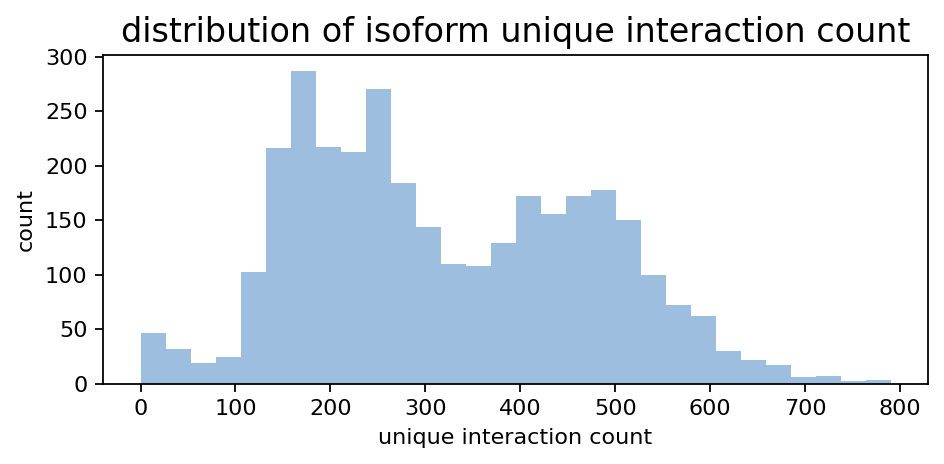

In [41]:
# plot distribution of unique count
plt.figure(figsize=(6, 3), dpi=160)
plt.hist(unique_interaction_isoform_bg["unique_interaction_count"], bins = 30, width = 27, color = "#9dbedf")
plt.ylabel("count", fontsize=10)
plt.xlabel("unique interaction count", fontsize=10)   
# plt.xticks(range(0, max(TF_isoform_unique_interaction["in cluster4 ratio"]), 2))
# plt.yticks(range(0, 250, 50))
# plt.yscale("log")
plt.title("distribution of isoform unique interaction count", fontsize=15)  
plt.tight_layout() 
plt.savefig('../data/Section5&6_Isoform/image/isoform_unique_interaction_count_distribution_background.pdf')

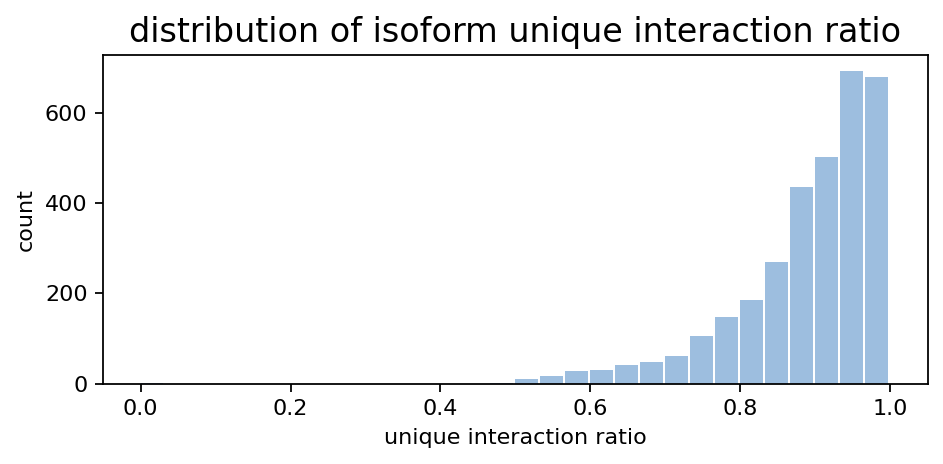

In [42]:
# plot distribution of unique ratio
plt.figure(figsize=(6, 3), dpi=160)
plt.hist(unique_interaction_isoform_bg["unique_interaction_ratio"], bins = 30, width = 0.03, color = "#9dbedf")
plt.ylabel("count", fontsize=10)
plt.xlabel("unique interaction ratio", fontsize=10)   
plt.title("distribution of isoform unique interaction ratio", fontsize=15)  
plt.tight_layout() 
plt.savefig('../data/Section5&6_Isoform/image/isoform_unique_interaction_ratio_distribution_background.pdf')

In [43]:
TF_isoform_unique_interaction_bg = wq_calculate_unique_regulon_statistics_by_TF(unique_interaction_isoform_bg, 
                                                                             flag_save = True, path_csv = "../data/Section5&6_Isoform/unique_interaction_isoform_byTF_background.csv")
# TF_isoform_unique_interaction_bg = pd.read_csv("../data/Section5&6_Isoform/unique_interaction_isoform_byTF_background.csv", index_col = 0)
TF_isoform_unique_interaction_bg

,TFname,count,unique_interaction_count_mean,unique_interaction_count_var,unique_interaction_count_std,unique_interaction_count_max,unique_interaction_count_min,unique_interaction_ratio_mean,unique_interaction_ratio_var,unique_interaction_ratio_std,unique_interaction_ratio_max,unique_interaction_ratio_min,unique_interaction_count_cv,unique_interaction_count_range,unique_interaction_ratio_cv,unique_interaction_ratio_range
0,AATF,1,516.0,NaN,NaN,516,516,0.966292,NaN,NaN,0.966292,0.966292,NaN,0,NaN,0.000000
1,ABL1,1,218.0,NaN,NaN,218,218,0.990909,NaN,NaN,0.990909,0.990909,NaN,0,NaN,0.000000
2,ACTL6A,2,387.0,24200.0,155.563492,497,277,0.927521,0.000008,0.002841,0.929530,0.925512,0.401973,220,0.003063,0.004018
3,ADAR,2,461.0,44402.0,210.717821,610,312,0.890445,0.000913,0.030213,0.911809,0.869081,0.457089,298,0.033930,0.042728
4,ADNP2,1,336.0,NaN,NaN,336,336,0.979592,NaN,NaN,0.979592,0.979592,NaN,0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,ZSCAN9,1,589.0,NaN,NaN,589,589,0.957724,NaN,NaN,0.957724,0.957724,NaN,0,NaN,0.000000
1713,ZXDA,1,482.0,NaN,NaN,482,482,0.964000,NaN,NaN,0.964000,0.964000,NaN,0,NaN,0.000000
1714,ZXDB,1,147.0,NaN,NaN,147,147,1.000000,NaN,NaN,1.000000,1.000000,NaN,0,NaN,0.000000
1715,ZXDC,2,498.5,7564.5,86.974134,560,437,0.869679,0.000178,0.013353,0.879121,0.860236,0.174472,123,0.015354,0.018885


In [44]:
# assign threshold by cluster identified in section 4
TF_isoform_unique_interaction = pd.read_csv("../data/Section5&6_Isoform/unique_interaction_isoform_byTF_clusterinfo.csv", index_col = 0)
focus_TFs = TF_isoform_unique_interaction[TF_isoform_unique_interaction["count"]>1]
focus_TFs = focus_TFs[focus_TFs["in cluster4 ratio"]==1]
# focus_TFs.to_csv("../data/Section5&6_Isoform/unique_interaction_isoform_byTF_cluster4_identical_TFs.csv", index = True, sep = ",")
focus_TFs

,TFname,count,in cluster4,in cluster4 ratio,unique_interaction_count_mean,unique_interaction_count_var,unique_interaction_count_std,unique_interaction_count_max,unique_interaction_count_min,unique_interaction_ratio_mean,unique_interaction_ratio_var,unique_interaction_ratio_std,unique_interaction_ratio_max,unique_interaction_ratio_min,unique_interaction_count_cv,unique_interaction_count_range,unique_interaction_ratio_cv,unique_interaction_ratio_range
ATF3,ATF3,4,4.0,1.0,69.500000,499.000000,22.338308,102,51,0.446819,0.003927,0.062664,0.534031,0.395349,0.321415,51,0.140245,0.138683
BATF2,BATF2,3,3.0,1.0,97.666667,785.333333,28.023799,125,69,0.599401,0.005919,0.076933,0.672043,0.518797,0.286933,56,0.128349,0.153246
CAMTA1,CAMTA1,2,2.0,1.0,111.000000,98.000000,9.899495,118,104,0.652352,0.000410,0.020244,0.666667,0.638037,0.089185,14,0.031033,0.028630
CHURC1,CHURC1,3,3.0,1.0,87.333333,126.333333,11.239810,97,75,0.507966,0.000864,0.029398,0.541899,0.490196,0.128700,22,0.057874,0.051703
ESRRA,ESRRA,2,2.0,1.0,125.000000,72.000000,8.485281,131,119,0.686472,0.000214,0.014617,0.696809,0.676136,0.067882,12,0.021294,0.020672
HELT,HELT,2,2.0,1.0,126.000000,32.000000,5.656854,130,122,0.692159,0.000092,0.009568,0.698925,0.685393,0.044896,8,0.013824,0.013531
HMGA2,HMGA2,5,5.0,1.0,62.000000,463.500000,21.529050,91,38,0.407002,0.004252,0.065207,0.478947,0.336283,0.347243,53,0.160213,0.142664
HOPX,HOPX,3,3.0,1.0,93.000000,684.000000,26.153394,111,63,0.556819,0.005186,0.072015,0.600000,0.473684,0.281219,48,0.129333,0.126316
HOXA1,HOXA1,2,2.0,1.0,135.500000,40.500000,6.363961,140,131,0.738262,0.000082,0.009077,0.744681,0.731844,0.046967,9,0.012296,0.012837
HOXB8,HOXB8,2,2.0,1.0,96.500000,12.500000,3.535534,99,94,0.663131,0.000067,0.008186,0.668919,0.657343,0.036638,5,0.012344,0.011576


In [45]:
mid_mean = max(focus_TFs["unique_interaction_ratio_mean"])
mid_range = max(focus_TFs["unique_interaction_ratio_range"])
print("threshold of mean:", mid_mean)
print("threshold of range:", mid_range)

threshold of mean: 0.7382622132414121
threshold of range: 0.1532460182714851


In [46]:
TF_isoform_unique_interaction_filter_bg = TF_isoform_unique_interaction_bg[TF_isoform_unique_interaction_bg["count"]!=1]

pearson r=-5.33e-01
p=4.73e-58


/storage/Pdisk7/wq/miniconda3/envs/PRnet/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


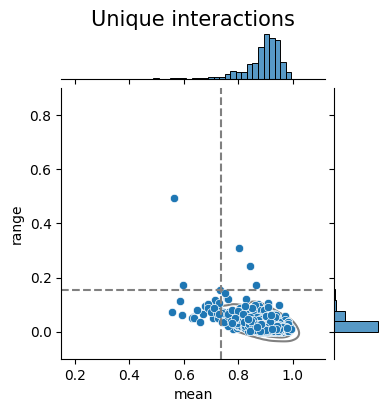

In [49]:
wq_plot_unique_interaction_statistic(TF_isoform_unique_interaction_filter_bg, x="unique_interaction_ratio_mean", y="unique_interaction_ratio_range", 
                                     title="Unique interactions", xlabel="mean", ylabel="range",
                                     vline = True, v = mid_mean, hline = True, h = mid_range,
                                     x_lim=(0.15, 1.12),
                                     y_lim=(-0.1, 0.9),
                                     flag_save = True, path_fig = "../data/Section5&6_Isoform/image/unique_interaction_mean_range_background.pdf")